In [1]:
import os
import sys
os.getcwd()

'c:\\Users\\ebaca\\Desktop\\Phys 417\\Final Project - HEP Tagging'

In [2]:
# importing libraries & sending tensors to GPU

# neural network packages
import torch
import torch.nn as nn
from torch.nn import Transformer
from torch import Tensor
from torch.utils.data import DataLoader
sys.path.append('..\\..\\PHYS417_Project')
from nnrunner import NetRunner

# data packages
import numpy as np
import math
import pandas as pd
import sklearn.preprocessing as prep
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import fndict as fd

# visual packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tqdm
import warnings

# Create a torch.device object to tell pytorch where to store your tensors: cpu or gpu
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

<b>About the Dataset</b>

<u>Tag</u>: the type of the original particles involved in the collision

<u>Jet</u>: collection of particles that hadronized (decayed) together into a stable particle

Per jet, variable number of constituents (rows) with 5 features (columns):
1. $p_T$: transverse momentum as a fraction of the jet total
2. $\eta$: angular coordinate relative to jet center
3. $\phi$: angular coordinate relative to jet center
4. $E$: energy from constituent
5. $\Delta R = \sqrt{\eta^2 + \phi^2}$

#### Preparing the Data

In [3]:
# # ---- STEP 1: establishing training features (x) and training targets (y) data -----------------------
# print("--Establishing Training Features/Targets--")

# # while training, model enters in the training features (x) and evaluates against the training targets (y)
# trfeat = np.load('..\\..\\PHYS417_Project\\data_1_tiled.npz')['x']
# # the testing data is used to evaluate the model's performance after training for predictions on unseen data
# trtarget = np.load('..\\..\\PHYS417_Project\\data_1_tiled.npz')['y']

# print("trfeat:", trfeat.shape, "\ntrtarget:", trtarget.shape)



# # ---- STEP 2: normalizing/shaping data  --------------------------------------------------------------
# print("\n --Normalizing/Shaping Data--")

# # Reducing to 2D for scaling, then reshaping back to 3D afterwards
# scaler = prep.StandardScaler()

# # traing features
# trfeat_2d = trfeat.reshape((trfeat.shape[0], -1))
# trfeat_2d = scaler.fit_transform(trfeat_2d)
# trfeat = trfeat_2d.reshape(trfeat.shape)
# print("trfeat reduced, reshaped:", trfeat_2d.shape, trfeat.shape)

# # training targets
# trtarget_2d = trtarget.reshape((trtarget.shape[0], -1))
# trtarget_2d = scaler.fit_transform(trtarget_2d)
# trtarget = trtarget_2d.reshape(trtarget.shape)
# print("trtarget reduced, reshaped:", trtarget_2d.shape, trtarget.shape)



# # ---- STEP 3: splitting data into training, validation, and testing sets -----------------------------
# print("\n --Splitting Data and Sending to GPU--")
# # the validation data is used to visualize/evaluate the model's performance throughout training to help with tuning hyperparameters

# # shuffling for random selection
# trfeat, trtarget = shuffle(trfeat, trtarget, random_state=0) 


# # splitting data into training, testing, and validation sets
# trfeat = trfeat[1000:] 
# print("trfeat:", trfeat.shape)

# trtarget = trtarget[1000:]
# print("trtarget:", trtarget.shape)

# vafeat = trfeat[:1000] 
# print("vafeat:", vafeat.shape)

# vatarget = trtarget[:1000] 
# print("vatarget:", vatarget.shape)


# # sending data to GPU
# with warnings.catch_warnings(): # booo warnings
#     warnings.simplefilter("ignore")

#     trfeat = torch.tensor(torch.from_numpy(trfeat), dtype=torch.float32).to(DEVICE)
#     trtarget = torch.tensor(torch.from_numpy(trtarget), dtype=torch.float32).to(DEVICE)
#     vafeat = torch.tensor(torch.from_numpy(vafeat), dtype=torch.float32).to(DEVICE)
#     vatarget = torch.tensor(torch.from_numpy(vatarget), dtype=torch.float32).to(DEVICE)

In [25]:
# ---- STEP 1: establishing training features (x) and training targets (y) data -----------------------
print("--Establishing Training Features/Targets--")

# while training, model enters in the training features (x) and evaluates against the training targets (y)

x1 = np.load('..\\..\\PHYS417_Project\\data_1_tiled.npz')['x']
x2 = np.load('..\\..\\PHYS417_Project\\data_2_tiled.npz')['x']
x = np.concatenate((x1, x2), axis=0)

y1 = np.load('..\\..\\PHYS417_Project\\data_1_tiled.npz')['y']
y2 = np.load('..\\..\\PHYS417_Project\\data_2_tiled.npz')['y']
y = np.concatenate((y1, y2), axis=0)

print("features (x):", x.shape, "\ntargets (y):", y.shape)



# ---- STEP 2: splitting data into training, validation, and testing sets -----------------------------
print("\n --Splitting Data--")

# shuffling for random selection, setting seed to 0 for reproduceability below
x, y = shuffle(x, y, random_state=0) 

# splitting data into training and testing sets
# the testing data is used to evaluate the model's performance after training for predictions on unseen data
# test_size = 0.2 means 20% of the data is for testing and 80% for training
trfeat, tefeat, trtarget, tetarget = train_test_split(x, y, test_size=0.2, random_state=0)

# splitting data again to get validation set
# the validation data is used to visualize/evaluate performance during training to help with tuning 
# 0.25 x 0.8 = 0.2
trfeat, vafeat, trtarget, vatarget = train_test_split(trfeat, trtarget, test_size=0.25, random_state=0) 

print("Training set:", trfeat.shape, trtarget.shape)
print("Validation set:", vafeat.shape, vatarget.shape)
print("Testing set:", tefeat.shape, tetarget.shape)



# ---- STEP 3: normalizing/shaping data  --------------------------------------------------------------
print("\n --Normalizing/Shaping Data and Sending to GPU--")

# Reducing to 2D for scaling, then reshaping back to 3D afterwards
scaler = prep.StandardScaler()

# training features
trfeat_2d = trfeat.reshape((trfeat.shape[0], -1))
scaler.fit(trfeat_2d)
trfeat_2d = scaler.transform(trfeat_2d)
trfeat = trfeat_2d.reshape(trfeat.shape)
print("trfeat reduced, reshaped:", trfeat_2d.shape, trfeat.shape)

# testing features
tefeat_2d = tefeat.reshape((tefeat.shape[0], -1))
tefeat_2d = scaler.transform(tefeat_2d)
tefeat = tefeat_2d.reshape(tefeat.shape)
print("tefeat reduced, reshaped:", tefeat_2d.shape, tefeat.shape)


# sending data to GPU
with warnings.catch_warnings(): # booo warnings
    warnings.simplefilter("ignore")

    trfeat = torch.tensor(torch.from_numpy(trfeat), dtype=torch.float32).to(DEVICE)
    trtarget = torch.tensor(torch.from_numpy(trtarget), dtype=torch.float32).to(DEVICE)

    vafeat = torch.tensor(torch.from_numpy(vafeat), dtype=torch.float32).to(DEVICE)
    vatarget = torch.tensor(torch.from_numpy(vatarget), dtype=torch.float32).to(DEVICE)
    
    tefeat = torch.tensor(torch.from_numpy(tefeat), dtype=torch.float32).to(DEVICE)
    tetarget = torch.tensor(torch.from_numpy(tetarget), dtype=torch.float32).to(DEVICE)

--Establishing Training Features/Targets--
features (x): (20000, 188, 5) 
targets (y): (20000, 5)

 --Splitting Data--
Training set: (12000, 188, 5) (12000, 5)
Validation set: (4000, 188, 5) (4000, 5)
Testing set: (4000, 188, 5) (4000, 5)

 --Normalizing/Shaping Data and Sending to GPU--
trfeat reduced, reshaped: (12000, 940) (12000, 188, 5)
tefeat reduced, reshaped: (4000, 940) (4000, 188, 5)


In [5]:
# object with data for later
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Create the dataset
trainers = MyDataset(trfeat, trtarget)

#### Build Model & Initialize

In [6]:
# # ---- BUILDING THE MODEL -----------------------------
# class ParticleClassifier(nn.Module):
#     def __init__(self, num_layers, dim_model, num_heads, dim_feedforward, dropout=0.1):
#         super(ParticleClassifier, self).__init__()

#         self.transformer = nn.Transformer(d_model = dim_model, 
#                                           nhead = num_heads, 
#                                           num_encoder_layers = num_layers, 
#                                           num_decoder_layers = num_layers, 
#                                           dim_feedforward = dim_feedforward, 
#                                           dropout = dropout)
#         self.linear = nn.Linear(dim_model, 5)  # 5 for the number of final state particles

#     def forward(self, src, src_mask=None, src_key_padding_mask=None):
#         src = src.permute(1, 0, 2)  # Transformer expects src to be of shape (sequence length, batch size, features)
#         out = self.transformer(src=src, src_mask=src_mask, src_key_padding_mask=src_key_padding_mask)
#         out = out.permute(1, 0, 2)  # Convert back to (batch size, sequence length, features)
#         out = self.linear(out[:, -1])  # Use the last output only

#         return out


# # ---- INITIALIZING MODEL -----------------------------
# classifier = ParticleClassifier(
#     num_layers = 2, 
#     dim_model = trfeat.shape[1], # embedded dimension must be divisible by num_heads
#     num_heads = fd.highest_divisor(trfeat.shape[1]), 
#     dim_feedforward = 512 
#     ).to(DEVICE)

In [17]:
# ---- BUILDING THE MODEL -----------------------------
class ParticleClassifier(nn.Module):
    def __init__(self,
                 num_encoder_layers,
                 embedding_size,
                 num_heads,
                 num_classes,
                 dim_feedforward=512,
                 dropout=0.1):
        super(ParticleClassifier, self).__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embedding_size,
                                       nhead=num_heads,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout),
            num_layers=num_encoder_layers)
        self.generator = nn.Linear(embedding_size, num_classes)
        # self.positional_encoding = PositionalEncoding(
        #     embedding_size, dropout=dropout)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(embedding_size)

    def forward(self, src, src_mask=None, src_padding_mask=None):
        if src.dim() == 2:
            src = src.unsqueeze(1)
        # src = self.positional_encoding(src)
        outs = self.transformer(src, src_mask, src_padding_mask)
        # return self.generator(outs.mean(dim=1))
        outs = self.adaptive_pool(outs.transpose(1, 2)).transpose(1, 2)
        # outs = outs.transpose(1, 2)
        return self.generator(outs.squeeze(1))

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer(self.positional_encoding(src), src_mask)


# ---- INITIALIZING MODEL -----------------------------
classifier = ParticleClassifier(
    num_encoder_layers = 2, 
    embedding_size = 5,  # number of properties per constituent
    num_heads = fd.highest_divisor(5), 
    num_classes = 5,  # number of final state particles
    dim_feedforward = 15,
    dropout = 0.1
).to(DEVICE)

#### Train Model

<b>Hyperparameters</b>

In [18]:
loss_fn = torch.nn.CrossEntropyLoss()

# betas are hyperparameters that control the exponential moving averages
# eps is a small constant added to improve numerical stability by preventing division by zero
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# Fair warning: you might get an "out of memory" error when training
# If that happens, try reducing the batch size
epochs = 20
batch_size = 5

<b>Begin Training with Training Data</b>

In [19]:
# trlosses = []
# valosses = []

# trDataLoader = DataLoader(trainers, batch_size=batch_size)

# from timeit import default_timer as timer
# train = fd.trainer

# for epoch in range(1, epochs+1):
    
#     classifier.train()
#     total_loss = 0

#     start_time = timer()
#     for batch in trDataLoader:
        
#         inputs, targets = batch
#         optimizer.zero_grad()

#         # forward pass
#         output = classifier(inputs)
        
#         loss = loss_fn(output, targets.long())

#         # backward pass and optimization
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#     #---------------------------#
#     end_time = timer()
    
#     avg_loss = total_loss / len(trDataLoader)
#     trlosses.append(avg_loss)


#     val_loss = train.evaluate(classifier, batch_size, vafeat, loss_fn)
#     valosses.extend(val_loss)

#     print(f"Epoch: {epoch}, Loss: {avg_loss}, Time: {(end_time - start_time):.3f}s")

In [20]:
# runner.simpleload(np.array(trfeat.cpu()), np.array(trtarget.cpu()))
# runner = NetRunner(withCuda=torch.cuda.is_available())
# runner.fit(classifier, lr=0.0001, epochs=epochs, optimizer='adam', lossFunc='cross_entropy')
# runner.train(batch=False)

In [21]:
# trfeat = trfeat.float()
trtarget = trtarget.long() # convert to 64-bit integer for CrossEntropyLoss

# vafeat = vafeat.float()
vatarget = vatarget.long()

# tefeat = tefeat.float()
# tetarget = tetarget.long()

# Training Loop ---------------------------------------------------------------------------------------

trlosses = []
valosses = []

for epoch in tqdm.trange(epochs):
    
    optimizer.zero_grad()
    
    train_outputs = classifier(trfeat)
    
    loss = loss_fn(train_outputs, trtarget)
    
    trlosses.append(loss.item())
    
    loss.backward()
    
    optimizer.step()
    
    # Compute Validation Accuracy ----------------------------------------------------------------------
    
    with torch.no_grad(): # Telling PyTorch we aren't passing inputs to network for training purpose
        
        validation_outputs = classifier(vafeat)
        
        correct = (torch.argmax(validation_outputs, dim=1) == 
                   vatarget).type(torch.FloatTensor)
        
        valosses.append(correct.mean())

100%|██████████| 20/20 [06:33<00:00, 19.66s/it]


<b>Visualizing the Training</b>

Test Accuracy: 0.238


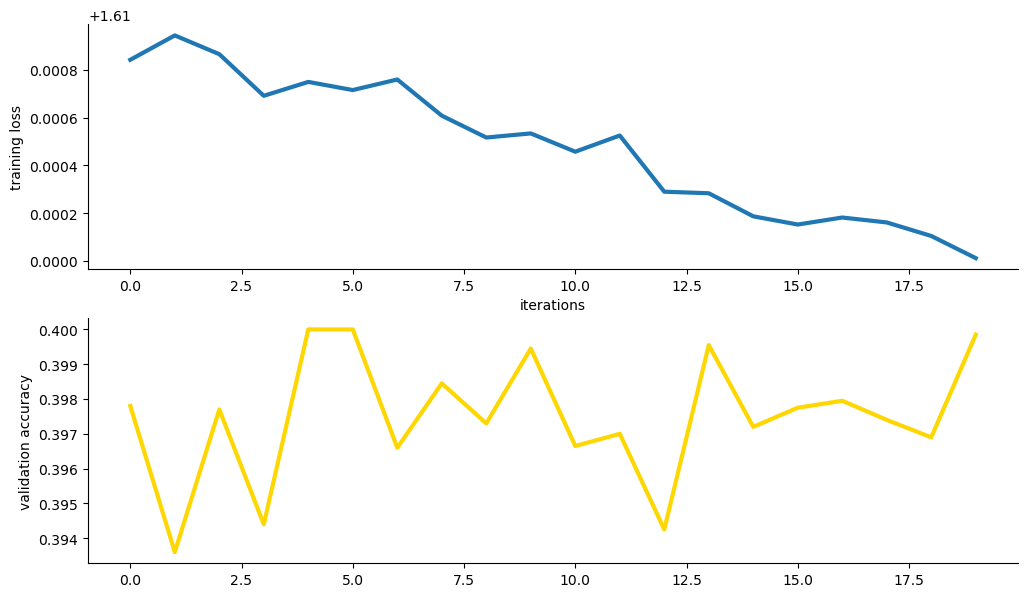

In [32]:
# Plot the loss
plt.figure(figsize = (12, 7))

plt.subplot(2, 1, 1)
plt.plot(trlosses, linewidth = 3)
# plt.plot(runner.losses, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("iterations")
sns.despine()

plt.subplot(2, 1, 2)
plt.plot(valosses, linewidth = 3, color = 'gold')
# plt.plot(runner.accuracies, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()


test_outputs = classifier(tefeat)
_ignore_, predicted = torch.max(test_outputs, 1)
correct = (predicted == tetarget).float()
accuracy = correct.mean().item()
print(f'Test Accuracy: {accuracy:.3f}')